TF Version: 2.0.0-beta1
Base Directory: /Users/kaymunamin/.keras/datasets/flower_photos
Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
daisy
dandelion
roses
sunflowers
tulipsModel: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5

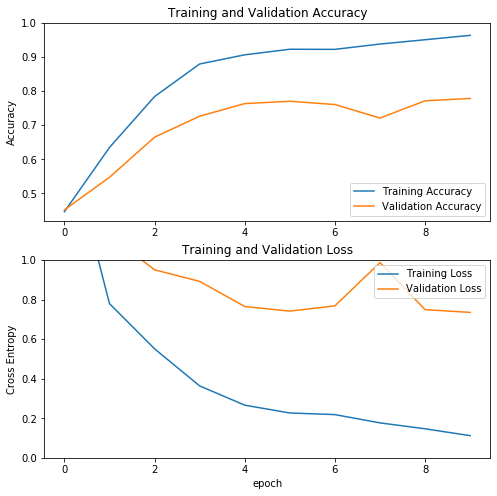

Number of layers in the base model:  155
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165       
Total params: 2,626,821
Trainable params: 2,231,429
Non-trainable params: 395,392
_________________________________________________________________
Number of trainable variables = 60
Epoch 1/5
46/46 [===========

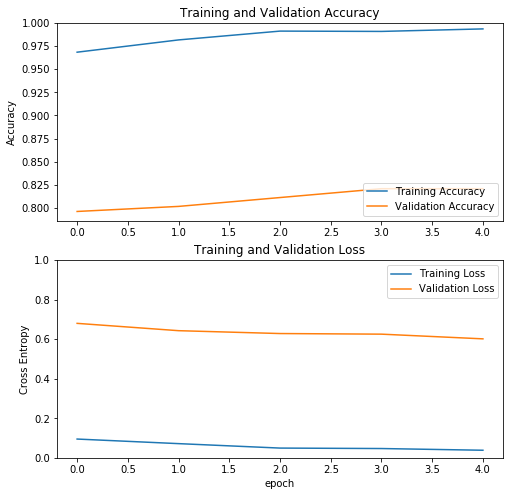

In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals


'''

pip3 install tensorflow==2.0.0-beta1 
python3 -m pip install matplotlib

pip3 install pillow

python3 -m pip install --user numpy scipy matplotlib ipython jupyter pandas sympy nose

See version:

Pillow Version:
python3
>>> print(PIL.__version__)

Reference:
https://colab.research.google.com/github/tensorflow/examples/blob/master/community/en/flowers_tf_lite.ipynb#scrollTo=z4gTv7ig2vMh
https://codelabs.developers.google.com/codelabs/recognize-flowers-with-tensorflow-on-android/#0

'''



import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt
import PIL


print("TF Version: " + tf.__version__)

_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL, fname="flower_photos.tgz", extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

print("Base Directory: " + base_dir)

IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

for image_batch, label_batch in train_generator:
  break

image_batch.shape, label_batch.shape

print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

!cat labels.txt

IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.trainable = False


model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

epochs = 10

history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

model.summary()

print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

history_fine = model.fit(train_generator, epochs=5, validation_data=val_generator)

saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

